Reducción de la dimensionalidad

In [4]:
# === Configuración de rutas ===
TRAIN_PATH = "./data/dataset/X_train_scaled.csv"  
TEST_PATH  = "./data/dataset/X_test_scaled.csv"   
OUT_DIR    = "./data/output"                          
TARGET_VARIANCE = 0.95                             # 95% por defecto

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
import pickle

In [7]:
X_train = pd.read_csv(TRAIN_PATH)
X_test  = pd.read_csv(TEST_PATH)

    # Limpieza por si el índice está guardado como columna
for df in (X_train, X_test):
    if df.columns[0].lower() in ("unnamed: 0", "index", ""):
        df.drop(df.columns[0], axis=1, inplace=True)
    df[:] = df.apply(pd.to_numeric, errors="coerce")

print("Shapes → train:", X_train.shape, " test:", X_test.shape)


FileNotFoundError: [Errno 2] No such file or directory: './data/dataset/X_train_scaled.csv'

Componentes totales: 21 | k seleccionado (≥95%): 19
Varianza acumulada con k=19: 0.9577


,component,explained_variance_ratio,cumulative_variance_ratio
0,1,0.104386,0.104386
1,2,0.094185,0.198572
2,3,0.068059,0.266631
3,4,0.063227,0.329858
4,5,0.057610,0.387468
5,6,0.056340,0.443808
6,7,0.054213,0.498021
7,8,0.049778,0.547799
8,9,0.047441,0.595240
9,10,0.046114,0.641354


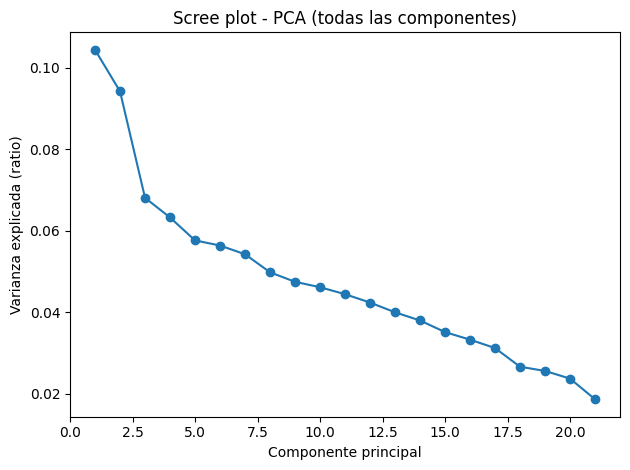

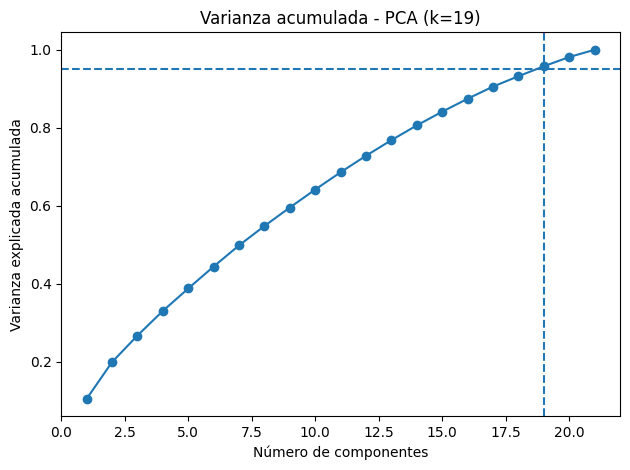

In [ ]:
pca_full = PCA()
pca_full.fit(X_train.values)
explained_var = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# Selección de k (mínimo con ≥ TARGET_VARIANCE)
k = int(np.searchsorted(cum_explained, TARGET_VARIANCE) + 1)
print(f"Componentes totales: {len(explained_var)} | k seleccionado (≥{int(TARGET_VARIANCE*100)}%): {k}")
print(f"Varianza acumulada con k={k}: {cum_explained[k-1]:.4f}")

# Tabla de varianza explicada
var_table = pd.DataFrame({
    'component': np.arange(1, len(explained_var)+1),
    'explained_variance_ratio': explained_var,
    'cumulative_variance_ratio': cum_explained
})
display(var_table.head(25))

# Gráficos
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada (ratio)')
plt.title('Scree plot - PCA (todas las componentes)')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
plt.axhline(y=TARGET_VARIANCE, linestyle='--')
plt.axvline(x=k, linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title(f'Varianza acumulada - PCA (k={k})')
plt.tight_layout()
plt.show()

In [ ]:
# Refit con k componentes y transformación de train/test 
pca_k = PCA(n_components=k, svd_solver='full', random_state=0)
pca_k.fit(X_train.values)
Z_train = pca_k.transform(X_train.values)
Z_test  = pca_k.transform(X_test.values)
print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)

Z_train: (6819, 19) Z_test: (2923, 19)


In [ ]:
# === Guardado de resultados y artefactos ===
out_dir = Path(OUT_DIR)
train_out = out_dir / f"X_train_pca_k{k}.csv"
test_out  = out_dir / f"X_test_pca_k{k}.csv"
var_out   = out_dir / "pca_variance_report.csv"
meta_out  = out_dir / "pca_metadata.json"
model_out = out_dir / f"pca_model_k{k}.pkl"

pd.DataFrame(Z_train).to_csv(train_out, index=False)
pd.DataFrame(Z_test).to_csv(test_out, index=False)
var_table.to_csv(var_out, index=False)

meta = {
    "train_path": TRAIN_PATH,
    "test_path": TEST_PATH,
    "train_shape": tuple(X_train.shape),
    "test_shape": tuple(X_test.shape),
    "n_features": int(X_train.shape[1]),
    "k_selected": int(k),
    "target_variance": float(TARGET_VARIANCE),
    "achieved_variance": float(np.cumsum(pca_k.explained_variance_ratio_)[-1])
}
with open(meta_out, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

with open(model_out, "wb") as f:
    pickle.dump(pca_k, f)

print("Guardado:")
print("-", train_out)
print("-", test_out)
print("-", var_out)
print("-", meta_out)
print("-", model_out)

Guardado:
- data\output\X_train_pca_k19.csv
- data\output\X_test_pca_k19.csv
- data\output\pca_variance_report.csv
- data\output\pca_metadata.json
- data\output\pca_model_k19.pkl
